# Classyfing the contributions

Based on the assumption, that certain keywords are linked to specific classes of contribution, this notebook aimes to use Machine Learning to assign a contribution class to the description of the contribution which can be found within the documents and in the future should be extracted with the help of Fonduer.

The following dataset was created manually by the Labelteam and transformed by Thorben for the purpose of ML. Every contribution is linked to a class_label.

In [1]:
import pandas as pd

data = pd.read_excel("./labeled_contribution_samples.xlsx")

data

,contribution,class_label
0,analysed data,Formal analysis
1,analysed experiments,Formal analysis
2,analysed the data collection,Formal analysis
3,analysed transcriptomic,Formal analysis
4,analyzed data,Formal analysis
...,...,...
194,wrote manuscript draft,Writing - original draft
195,wrote paper,Writing - original draft
196,wrote programm,Software
197,wrote R package for data fittting,Software


In [2]:
import numpy as np
label_dict = dict(enumerate(np.sort(data.class_label.unique()).flatten(),0))

There are 15 class labels available:

In [3]:
label_dict

{0: 'Conceptualization / Conceptualisation',
 1: 'Data curation',
 2: 'Formal analysis',
 3: 'Investigation',
 4: 'Methodology',
 5: 'Project administration',
 6: 'Resources',
 7: 'Software',
 8: 'Sonstiges',
 9: 'Supervision',
 10: 'Support',
 11: 'Validation',
 12: 'Visualization / Visualisation',
 13: 'Writing - original draft',
 14: 'Writing - review & editing'}

Assign a code to the respective class_labels

In [4]:
label_df = pd.DataFrame.from_dict(label_dict, orient = 'index', columns = ['class_label']).reset_index(names = 'label_code')

In [5]:
contributions_df = data.merge(label_df)

Shuffle the dataset.

In [6]:
contributions_df_shuffled = contributions_df.sample(frac=1).reset_index(drop=True)
contributions_df_shuffled

,contribution,class_label,label_code
0,prepared the manuscript,Writing - original draft,13
1,wrote first draft of the manuscript,Writing - original draft,13
2,commented on manuscript,Writing - review & editing,14
3,designed algorithms in,Software,7
4,conducted data analysis,Formal analysis,2
...,...,...,...
194,provided key comments,Writing - review & editing,14
195,supervised paper,Project administration,5
196,assisted analysis,Formal analysis,2
197,wrote programm,Software,7


Hot encoding of words in contribution

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

contributions_list = contributions_df_shuffled["contribution"].to_list()

# create a tokenizer, configured to only take the top N=1000 most common words
tokenizer = Tokenizer(num_words=1000)
# this builds the word index
tokenizer.fit_on_texts(contributions_list)

# this turns strings into lists of integer indices
sequences = tokenizer.texts_to_sequences(contributions_list)

# directly get the one-hot binary representation
one_hot_results = tokenizer.texts_to_matrix(contributions_list, mode='binary') 

# recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 223 unique tokens.


Create datasets for training, validating and testing. 
  
70 % / 20 % / 10 %

In [8]:
from tensorflow.keras.utils import to_categorical

# where to slice the dataset:
train_size = int(round(0.7 * contributions_df_shuffled.shape[0],0))
val_size = int(round(0.2 * contributions_df_shuffled.shape[0],0))
test_size = int(round(0.1 * contributions_df_shuffled.shape[0],0))

# slice data
train_data = one_hot_results[:train_size]
val_data = one_hot_results[train_size:train_size + val_size]
test_data = one_hot_results[train_size+val_size:]

# slice labels
train_labels = to_categorical(contributions_df_shuffled.label_code)[:train_size]
val_labels = to_categorical(contributions_df_shuffled.label_code)[train_size:train_size + val_size]
test_labels = to_categorical(contributions_df_shuffled.label_code)[train_size+val_size:]

In [9]:
len(train_labels[0])

15

### Simple ANN model


Building a first really simple model

In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import metrics

model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(15, activation='softmax'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=["accuracy"])

Training the ANN for 20 epochs with batch_size=64 and use the history object.

In [12]:
history = model.fit(train_data,
                    train_labels,
                    epochs=20,
                    batch_size=64,
                    validation_data=(val_data, val_labels))

Epoch 1/20
3/3 [==============================] - 1s 191ms/step - loss: 0.6811 - accuracy: 0.0935 - val_loss: 0.6637 - val_accuracy: 0.0250
Epoch 2/20
3/3 [==============================] - 0s 28ms/step - loss: 0.6566 - accuracy: 0.1079 - val_loss: 0.6406 - val_accuracy: 0.0250
Epoch 3/20
3/3 [==============================] - 0s 26ms/step - loss: 0.6302 - accuracy: 0.1223 - val_loss: 0.6147 - val_accuracy: 0.0250
Epoch 4/20
3/3 [==============================] - 0s 25ms/step - loss: 0.6009 - accuracy: 0.1007 - val_loss: 0.5845 - val_accuracy: 0.0250
Epoch 5/20
3/3 [==============================] - 0s 25ms/step - loss: 0.5674 - accuracy: 0.0863 - val_loss: 0.5517 - val_accuracy: 0.0750
Epoch 6/20
3/3 [==============================] - 0s 25ms/step - loss: 0.5309 - accuracy: 0.0791 - val_loss: 0.5166 - val_accuracy: 0.0750
Epoch 7/20
3/3 [==============================] - 0s 26ms/step - loss: 0.4923 - accuracy: 0.0504 - val_loss: 0.4801 - val_accuracy: 0.0750
Epoch 8/20
3/3 [==========

In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Visualize the loss and accuracy by using pyplot.

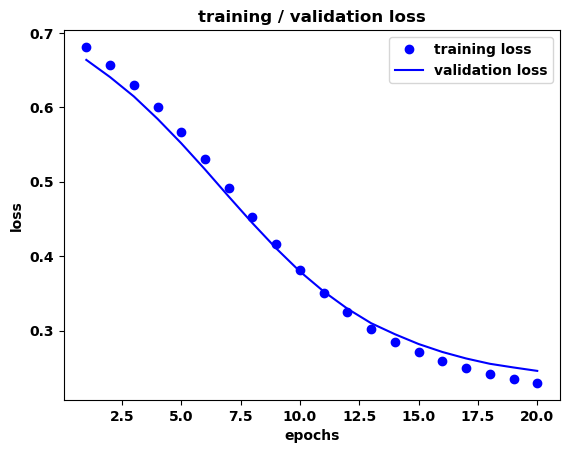

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training / validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

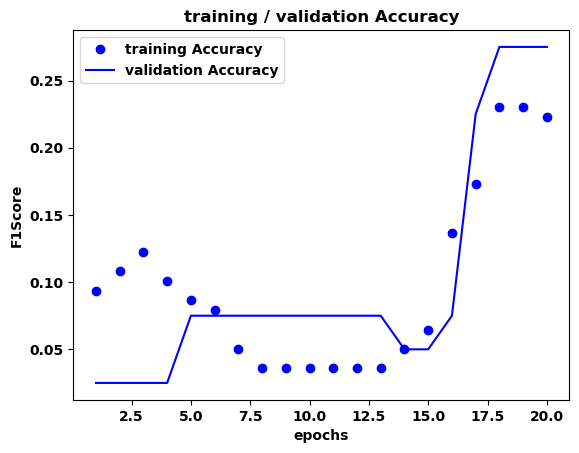

In [24]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='training Accuracy')
plt.plot(epochs, val_acc, 'b', label='validation Accuracy')
plt.title('training / validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('F1Score')
plt.legend()

plt.show()

In [19]:
results = model.evaluate(test_data, test_labels)

1/1 [==============================] - 0s 29ms/step - loss: 0.2397 - accuracy: 0.2500


In [20]:
results

[0.23972943425178528, 0.25]

The performance of this really simple model is not great, with an accuracy of 25 % for the test data. Lets add some parameter testing.

In [21]:
test_plan = {}
test_plan[0] = {"n_units": 32, "n_hidden_layers": 1, "n_epochs": 20, "n_batch_size": 64}
test_plan[1] = {"n_units": 32, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 64}
test_plan[2] = {"n_units": 32, "n_hidden_layers": 3, "n_epochs": 20, "n_batch_size": 64}
test_plan[3] = {"n_units": 64, "n_hidden_layers": 1, "n_epochs": 20, "n_batch_size": 64}
test_plan[4] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 64}
test_plan[5] = {"n_units": 64, "n_hidden_layers": 3, "n_epochs": 20, "n_batch_size": 64}
test_plan[6] = {"n_units": 128, "n_hidden_layers": 1, "n_epochs": 20, "n_batch_size": 64}
test_plan[7] = {"n_units": 128, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 64}
test_plan[8] = {"n_units": 128, "n_hidden_layers": 3, "n_epochs": 20, "n_batch_size": 64}
test_plan[9] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 50, "n_batch_size": 64}
test_plan[10] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 100, "n_batch_size": 64}
test_plan[11] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 32}
test_plan[12] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 16}
test_plan[13] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 20, "n_batch_size": 128}
test_plan[14] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 100, "n_batch_size": 16}
test_plan[15] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 150, "n_batch_size": 16}
test_plan[16] = {"n_units": 64, "n_hidden_layers": 2, "n_epochs": 200, "n_batch_size": 16}

In [22]:
result_dict = {}

for n in range(len(test_plan)):
    units = test_plan[n]["n_units"]
    hidden_layers = test_plan[n]["n_hidden_layers"]
    n_epochs = test_plan[n]["n_epochs"]
    n_batch_size = test_plan[n]["n_batch_size"]
    
    #initiate model
    model = models.Sequential()
    
    #add hidden layers
    if hidden_layers == 1:
        model.add(layers.Dense(units, activation='relu', input_shape=(1000,)))
    else:
        for i in range(hidden_layers):
            model.add(layers.Dense(units, activation='relu', input_shape=(1000,)))

    # add output layer
    model.add(layers.Dense(15, activation='softmax'))

    #compile model
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=["accuracy"])

    #fit model
    model.fit(train_data,
              train_labels,
              epochs=n_epochs,
              batch_size=n_batch_size,
              validation_data=(val_data, val_labels))

    results = model.evaluate(test_data, test_labels)
                               
    result_dict[n] = {"activation": "relu/softmax",  
                     "n_units": units, 
                     "n_hidden_layers": hidden_layers, 
                     "n_epochs": n_epochs,
                     "n_batch_size": n_batch_size,
                     "optimizer": "rmsprop", 
                     "loss": "binary_crossentropy",
                     "accuracy": results[1]}

Epoch 1/20
3/3 [==============================] - 1s 147ms/step - loss: 0.6973 - accuracy: 0.0791 - val_loss: 0.6900 - val_accuracy: 0.1250
Epoch 2/20
3/3 [==============================] - 0s 26ms/step - loss: 0.6865 - accuracy: 0.1583 - val_loss: 0.6833 - val_accuracy: 0.1250
Epoch 3/20
3/3 [==============================] - 0s 31ms/step - loss: 0.6789 - accuracy: 0.1942 - val_loss: 0.6773 - val_accuracy: 0.2250
Epoch 4/20
3/3 [==============================] - 0s 28ms/step - loss: 0.6722 - accuracy: 0.2230 - val_loss: 0.6716 - val_accuracy: 0.2500
Epoch 5/20
3/3 [==============================] - 0s 28ms/step - loss: 0.6655 - accuracy: 0.2446 - val_loss: 0.6658 - val_accuracy: 0.2500
Epoch 6/20
3/3 [==============================] - 0s 24ms/step - loss: 0.6586 - accuracy: 0.2806 - val_loss: 0.6598 - val_accuracy: 0.2250
Epoch 7/20
3/3 [==============================] - 0s 25ms/step - loss: 0.6515 - accuracy: 0.2878 - val_loss: 0.6533 - val_accuracy: 0.2250
Epoch 8/20
3/3 [==========

3/3 [==============================] - 0s 24ms/step - loss: 0.2850 - accuracy: 0.0791 - val_loss: 0.2933 - val_accuracy: 0.0750
Epoch 19/20
3/3 [==============================] - 0s 25ms/step - loss: 0.2747 - accuracy: 0.0791 - val_loss: 0.2826 - val_accuracy: 0.0750
Epoch 20/20
1/1 [==============================] - 0s 39ms/step - loss: 0.2775 - accuracy: 0.0000e+00
Epoch 1/20
3/3 [==============================] - 1s 147ms/step - loss: 0.6907 - accuracy: 0.0360 - val_loss: 0.6785 - val_accuracy: 0.1000
Epoch 2/20
3/3 [==============================] - 0s 24ms/step - loss: 0.6727 - accuracy: 0.0576 - val_loss: 0.6669 - val_accuracy: 0.1000
Epoch 3/20
3/3 [==============================] - 0s 23ms/step - loss: 0.6595 - accuracy: 0.0647 - val_loss: 0.6564 - val_accuracy: 0.1000
Epoch 4/20
3/3 [==============================] - 0s 23ms/step - loss: 0.6473 - accuracy: 0.0863 - val_loss: 0.6465 - val_accuracy: 0.1000
Epoch 5/20
3/3 [==============================] - 0s 26ms/step - loss: 0.

Epoch 15/20
3/3 [==============================] - 0s 25ms/step - loss: 0.2221 - accuracy: 0.3022 - val_loss: 0.2347 - val_accuracy: 0.2750
Epoch 16/20
3/3 [==============================] - 0s 24ms/step - loss: 0.2184 - accuracy: 0.3094 - val_loss: 0.2312 - val_accuracy: 0.2750
Epoch 17/20
3/3 [==============================] - 0s 26ms/step - loss: 0.2155 - accuracy: 0.2878 - val_loss: 0.2295 - val_accuracy: 0.2750
Epoch 18/20
3/3 [==============================] - 0s 25ms/step - loss: 0.2131 - accuracy: 0.2806 - val_loss: 0.2285 - val_accuracy: 0.3250
Epoch 19/20
3/3 [==============================] - 0s 26ms/step - loss: 0.2105 - accuracy: 0.3381 - val_loss: 0.2260 - val_accuracy: 0.3250
Epoch 20/20
1/1 [==============================] - 0s 39ms/step - loss: 0.2082 - accuracy: 0.3500
Epoch 1/20
3/3 [==============================] - 1s 147ms/step - loss: 0.6747 - accuracy: 0.0863 - val_loss: 0.6560 - val_accuracy: 0.1000
Epoch 2/20
3/3 [==============================] - 0s 25ms/step

Epoch 12/20
3/3 [==============================] - 0s 26ms/step - loss: 0.2134 - accuracy: 0.2446 - val_loss: 0.2265 - val_accuracy: 0.2750
Epoch 13/20
3/3 [==============================] - 0s 26ms/step - loss: 0.2096 - accuracy: 0.2734 - val_loss: 0.2227 - val_accuracy: 0.2750
Epoch 14/20
3/3 [==============================] - 0s 26ms/step - loss: 0.2059 - accuracy: 0.2662 - val_loss: 0.2218 - val_accuracy: 0.2750
Epoch 15/20
3/3 [==============================] - 0s 29ms/step - loss: 0.2013 - accuracy: 0.2950 - val_loss: 0.2220 - val_accuracy: 0.3250
Epoch 16/20
3/3 [==============================] - 0s 27ms/step - loss: 0.1969 - accuracy: 0.3669 - val_loss: 0.2176 - val_accuracy: 0.3250
Epoch 17/20
3/3 [==============================] - 0s 26ms/step - loss: 0.1929 - accuracy: 0.3525 - val_loss: 0.2134 - val_accuracy: 0.3250
Epoch 18/20
3/3 [==============================] - 0s 27ms/step - loss: 0.1863 - accuracy: 0.3525 - val_loss: 0.2137 - val_accuracy: 0.3000
Epoch 19/20
3/3 [===

Epoch 50/50
1/1 [==============================] - 0s 41ms/step - loss: 0.1591 - accuracy: 0.5500
Epoch 1/100
3/3 [==============================] - 1s 152ms/step - loss: 0.6845 - accuracy: 0.0360 - val_loss: 0.6648 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 25ms/step - loss: 0.6555 - accuracy: 0.0647 - val_loss: 0.6387 - val_accuracy: 0.0250
Epoch 3/100
3/3 [==============================] - 0s 24ms/step - loss: 0.6264 - accuracy: 0.0576 - val_loss: 0.6093 - val_accuracy: 0.0500
Epoch 4/100
3/3 [==============================] - 0s 24ms/step - loss: 0.5936 - accuracy: 0.0647 - val_loss: 0.5780 - val_accuracy: 0.0500
Epoch 5/100
3/3 [==============================] - 0s 26ms/step - loss: 0.5577 - accuracy: 0.0647 - val_loss: 0.5438 - val_accuracy: 0.0500
Epoch 6/100
3/3 [==============================] - 0s 26ms/step - loss: 0.5189 - accuracy: 0.0576 - val_loss: 0.5067 - val_accuracy: 0.0250
Epoch 7/100
3/3 [==============================] - 0s 25m

3/3 [==============================] - 0s 26ms/step - loss: 0.1149 - accuracy: 0.7842 - val_loss: 0.1851 - val_accuracy: 0.4000
Epoch 58/100
3/3 [==============================] - 0s 26ms/step - loss: 0.1120 - accuracy: 0.7914 - val_loss: 0.1842 - val_accuracy: 0.4000
Epoch 59/100
3/3 [==============================] - 0s 25ms/step - loss: 0.1092 - accuracy: 0.7986 - val_loss: 0.1825 - val_accuracy: 0.4000
Epoch 60/100
3/3 [==============================] - 0s 25ms/step - loss: 0.1065 - accuracy: 0.7986 - val_loss: 0.1813 - val_accuracy: 0.4000
Epoch 61/100
3/3 [==============================] - 0s 26ms/step - loss: 0.1039 - accuracy: 0.8058 - val_loss: 0.1804 - val_accuracy: 0.3750
Epoch 62/100
3/3 [==============================] - 0s 27ms/step - loss: 0.1011 - accuracy: 0.8201 - val_loss: 0.1800 - val_accuracy: 0.4000
Epoch 63/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0985 - accuracy: 0.8345 - val_loss: 0.1790 - val_accuracy: 0.4250
Epoch 64/100
3/3 [========

Epoch 15/20
5/5 [==============================] - 0s 15ms/step - loss: 0.2164 - accuracy: 0.3165 - val_loss: 0.2335 - val_accuracy: 0.3250
Epoch 16/20
5/5 [==============================] - 0s 15ms/step - loss: 0.2114 - accuracy: 0.3597 - val_loss: 0.2303 - val_accuracy: 0.3250
Epoch 17/20
5/5 [==============================] - 0s 15ms/step - loss: 0.2067 - accuracy: 0.3597 - val_loss: 0.2268 - val_accuracy: 0.3250
Epoch 18/20
5/5 [==============================] - 0s 15ms/step - loss: 0.2022 - accuracy: 0.3453 - val_loss: 0.2248 - val_accuracy: 0.3250
Epoch 19/20
5/5 [==============================] - 0s 14ms/step - loss: 0.1975 - accuracy: 0.4029 - val_loss: 0.2227 - val_accuracy: 0.3250
Epoch 20/20
1/1 [==============================] - 0s 43ms/step - loss: 0.1979 - accuracy: 0.3500
Epoch 1/20
9/9 [==============================] - 1s 42ms/step - loss: 0.6597 - accuracy: 0.1511 - val_loss: 0.6168 - val_accuracy: 0.2500
Epoch 2/20
9/9 [==============================] - 0s 9ms/step -

Epoch 12/100
9/9 [==============================] - 0s 9ms/step - loss: 0.1976 - accuracy: 0.3669 - val_loss: 0.2171 - val_accuracy: 0.3250
Epoch 13/100
9/9 [==============================] - 0s 9ms/step - loss: 0.1909 - accuracy: 0.3741 - val_loss: 0.2134 - val_accuracy: 0.3250
Epoch 14/100
9/9 [==============================] - 0s 9ms/step - loss: 0.1848 - accuracy: 0.3957 - val_loss: 0.2106 - val_accuracy: 0.3500
Epoch 15/100
9/9 [==============================] - 0s 9ms/step - loss: 0.1779 - accuracy: 0.4245 - val_loss: 0.2085 - val_accuracy: 0.3500
Epoch 16/100
9/9 [==============================] - 0s 9ms/step - loss: 0.1712 - accuracy: 0.4388 - val_loss: 0.2049 - val_accuracy: 0.3750
Epoch 17/100
9/9 [==============================] - 0s 10ms/step - loss: 0.1639 - accuracy: 0.4604 - val_loss: 0.2016 - val_accuracy: 0.3750
Epoch 18/100
9/9 [==============================] - 0s 10ms/step - loss: 0.1568 - accuracy: 0.4892 - val_loss: 0.1996 - val_accuracy: 0.3500
Epoch 19/100
9/9 [

9/9 [==============================] - 0s 9ms/step - loss: 0.0047 - accuracy: 0.9928 - val_loss: 0.2889 - val_accuracy: 0.5250
Epoch 71/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0044 - accuracy: 0.9928 - val_loss: 0.2941 - val_accuracy: 0.5250
Epoch 72/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0045 - accuracy: 0.9856 - val_loss: 0.2976 - val_accuracy: 0.5250
Epoch 73/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0041 - accuracy: 0.9928 - val_loss: 0.3027 - val_accuracy: 0.5250
Epoch 74/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0039 - accuracy: 0.9928 - val_loss: 0.3076 - val_accuracy: 0.5250
Epoch 75/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0038 - accuracy: 0.9928 - val_loss: 0.3102 - val_accuracy: 0.5250
Epoch 76/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0036 - accuracy: 0.9928 - val_loss: 0.3158 - val_accuracy: 0.5250
Epoch 77/100
9/9 [===============

9/9 [==============================] - 0s 8ms/step - loss: 0.0940 - accuracy: 0.8561 - val_loss: 0.1783 - val_accuracy: 0.4250
Epoch 29/150
9/9 [==============================] - 0s 14ms/step - loss: 0.0886 - accuracy: 0.8417 - val_loss: 0.1777 - val_accuracy: 0.4250
Epoch 30/150
9/9 [==============================] - 0s 10ms/step - loss: 0.0831 - accuracy: 0.8561 - val_loss: 0.1780 - val_accuracy: 0.4250
Epoch 31/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0784 - accuracy: 0.8633 - val_loss: 0.1766 - val_accuracy: 0.4250
Epoch 32/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0736 - accuracy: 0.8633 - val_loss: 0.1761 - val_accuracy: 0.4500
Epoch 33/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0691 - accuracy: 0.8633 - val_loss: 0.1771 - val_accuracy: 0.4500
Epoch 34/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0649 - accuracy: 0.8777 - val_loss: 0.1773 - val_accuracy: 0.5000
Epoch 35/150
9/9 [=============

9/9 [==============================] - 0s 9ms/step - loss: 0.0024 - accuracy: 0.9856 - val_loss: 0.3355 - val_accuracy: 0.5500
Epoch 87/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0024 - accuracy: 0.9856 - val_loss: 0.3395 - val_accuracy: 0.5500
Epoch 88/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0023 - accuracy: 0.9856 - val_loss: 0.3442 - val_accuracy: 0.5250
Epoch 89/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0022 - accuracy: 0.9928 - val_loss: 0.3465 - val_accuracy: 0.5500
Epoch 90/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0022 - accuracy: 0.9856 - val_loss: 0.3516 - val_accuracy: 0.5250
Epoch 91/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0021 - accuracy: 0.9856 - val_loss: 0.3545 - val_accuracy: 0.5250
Epoch 92/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0021 - accuracy: 0.9928 - val_loss: 0.3587 - val_accuracy: 0.5250
Epoch 93/150
9/9 [===============

9/9 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.9928 - val_loss: 0.5431 - val_accuracy: 0.5250
Epoch 145/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.9856 - val_loss: 0.5456 - val_accuracy: 0.5250
Epoch 146/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.9928 - val_loss: 0.5492 - val_accuracy: 0.5250
Epoch 147/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.9928 - val_loss: 0.5524 - val_accuracy: 0.5250
Epoch 148/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.9856 - val_loss: 0.5543 - val_accuracy: 0.5250
Epoch 149/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.9928 - val_loss: 0.5557 - val_accuracy: 0.5000
Epoch 150/150
1/1 [==============================] - 0s 44ms/step - loss: 0.2833 - accuracy: 0.6500
Epoch 1/200
9/9 [==============================] - 1s 41ms/step - lo

Epoch 52/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0188 - accuracy: 0.9712 - val_loss: 0.1965 - val_accuracy: 0.5000
Epoch 53/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0175 - accuracy: 0.9784 - val_loss: 0.2014 - val_accuracy: 0.4750
Epoch 54/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0161 - accuracy: 0.9784 - val_loss: 0.2034 - val_accuracy: 0.5000
Epoch 55/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0152 - accuracy: 0.9928 - val_loss: 0.2082 - val_accuracy: 0.4750
Epoch 56/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0139 - accuracy: 0.9928 - val_loss: 0.2104 - val_accuracy: 0.4750
Epoch 57/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0129 - accuracy: 0.9856 - val_loss: 0.2127 - val_accuracy: 0.5000
Epoch 58/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0121 - accuracy: 0.9928 - val_loss: 0.2172 - val_accuracy: 0.5000
Epoch 59/200
9/9 [==

9/9 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.9856 - val_loss: 0.4275 - val_accuracy: 0.5000
Epoch 111/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.9928 - val_loss: 0.4322 - val_accuracy: 0.5000
Epoch 112/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.9928 - val_loss: 0.4366 - val_accuracy: 0.5000
Epoch 113/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.9928 - val_loss: 0.4393 - val_accuracy: 0.5000
Epoch 114/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0014 - accuracy: 0.9928 - val_loss: 0.4434 - val_accuracy: 0.5000
Epoch 115/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0018 - accuracy: 0.9856 - val_loss: 0.4462 - val_accuracy: 0.5000
Epoch 116/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0018 - accuracy: 0.9928 - val_loss: 0.4499 - val_accuracy: 0.5000
Epoch 117/200
9/9 [========

9/9 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.9856 - val_loss: 0.6033 - val_accuracy: 0.5000
Epoch 169/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.9928 - val_loss: 0.6043 - val_accuracy: 0.5000
Epoch 170/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.9856 - val_loss: 0.6062 - val_accuracy: 0.5000
Epoch 171/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.9928 - val_loss: 0.6084 - val_accuracy: 0.5000
Epoch 172/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0013 - accuracy: 0.9928 - val_loss: 0.6120 - val_accuracy: 0.5000
Epoch 173/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.9928 - val_loss: 0.6125 - val_accuracy: 0.5000
Epoch 174/200
9/9 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.9856 - val_loss: 0.6142 - val_accuracy: 0.5000
Epoch 175/200
9/9 [========

In [23]:
pd.DataFrame.from_dict(result_dict, orient = "index")

,activation,n_units,n_hidden_layers,n_epochs,n_batch_size,optimizer,loss,accuracy
0,relu/softmax,32,1,20,64,rmsprop,binary_crossentropy,0.30
1,relu/softmax,32,2,20,64,rmsprop,binary_crossentropy,0.25
2,relu/softmax,32,3,20,64,rmsprop,binary_crossentropy,0.00
3,relu/softmax,64,1,20,64,rmsprop,binary_crossentropy,0.25
4,relu/softmax,64,2,20,64,rmsprop,binary_crossentropy,0.35
5,relu/softmax,64,3,20,64,rmsprop,binary_crossentropy,0.35
6,relu/softmax,128,1,20,64,rmsprop,binary_crossentropy,0.45
7,relu/softmax,128,2,20,64,rmsprop,binary_crossentropy,0.40
8,relu/softmax,128,3,20,64,rmsprop,binary_crossentropy,0.35
9,relu/softmax,64,2,50,64,rmsprop,binary_crossentropy,0.55


Using a small batch-size and high number of epochs delivers the best results regarding the accuracy.

In [37]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import metrics

model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(15, activation='softmax'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=["accuracy"])

history = model.fit(train_data,
                    train_labels,
                    epochs=100,
                    batch_size=16,
                    validation_data=(val_data, val_labels))

Epoch 1/100
9/9 [==============================] - 1s 44ms/step - loss: 0.6741 - accuracy: 0.1583 - val_loss: 0.6429 - val_accuracy: 0.2250
Epoch 2/100
9/9 [==============================] - 0s 11ms/step - loss: 0.6154 - accuracy: 0.2086 - val_loss: 0.5723 - val_accuracy: 0.2750
Epoch 3/100
9/9 [==============================] - 0s 9ms/step - loss: 0.5296 - accuracy: 0.2230 - val_loss: 0.4767 - val_accuracy: 0.2750
Epoch 4/100
9/9 [==============================] - 0s 9ms/step - loss: 0.4284 - accuracy: 0.2374 - val_loss: 0.3820 - val_accuracy: 0.2750
Epoch 5/100
9/9 [==============================] - 0s 8ms/step - loss: 0.3397 - accuracy: 0.2230 - val_loss: 0.3108 - val_accuracy: 0.2750
Epoch 6/100
9/9 [==============================] - 0s 9ms/step - loss: 0.2806 - accuracy: 0.2230 - val_loss: 0.2694 - val_accuracy: 0.2750
Epoch 7/100
9/9 [==============================] - 0s 9ms/step - loss: 0.2491 - accuracy: 0.2230 - val_loss: 0.2480 - val_accuracy: 0.2750
Epoch 8/100
9/9 [========

9/9 [==============================] - 0s 9ms/step - loss: 0.0116 - accuracy: 0.9712 - val_loss: 0.2346 - val_accuracy: 0.5250
Epoch 60/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0108 - accuracy: 0.9856 - val_loss: 0.2366 - val_accuracy: 0.5250
Epoch 61/100
9/9 [==============================] - 0s 8ms/step - loss: 0.0100 - accuracy: 0.9856 - val_loss: 0.2420 - val_accuracy: 0.5250
Epoch 62/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0094 - accuracy: 0.9856 - val_loss: 0.2449 - val_accuracy: 0.5250
Epoch 63/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0089 - accuracy: 0.9784 - val_loss: 0.2487 - val_accuracy: 0.5250
Epoch 64/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0081 - accuracy: 0.9856 - val_loss: 0.2545 - val_accuracy: 0.5250
Epoch 65/100
9/9 [==============================] - 0s 9ms/step - loss: 0.0077 - accuracy: 0.9928 - val_loss: 0.2530 - val_accuracy: 0.5250
Epoch 66/100
9/9 [===============

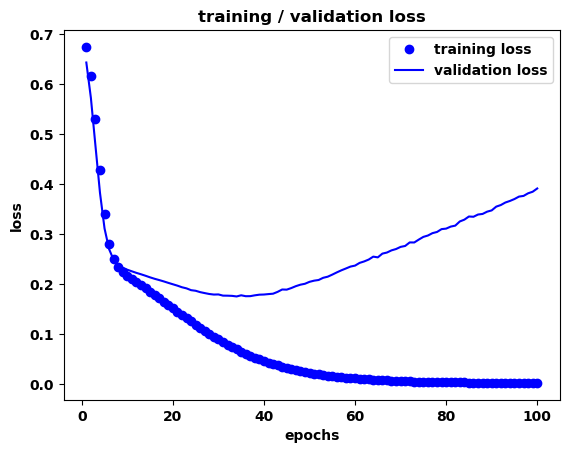

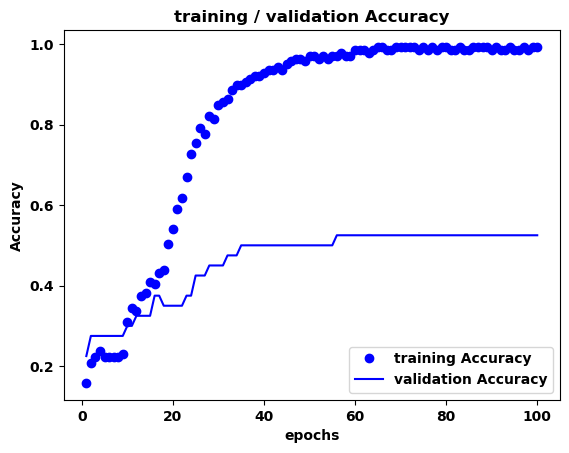

In [38]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training / validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='training Accuracy')
plt.plot(epochs, val_acc, 'b', label='validation Accuracy')
plt.title('training / validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [39]:
results = model.evaluate(test_data, test_labels)

1/1 [==============================] - 0s 28ms/step - loss: 0.1576 - accuracy: 0.7000


### Neuer Datensatz

In [29]:
data_new = pd.read_excel("./labeled_contribution_samples_2.xlsx")

label_dict_new = dict(enumerate(np.sort(data.class_label.unique()).flatten(),0))

label_df_new = pd.DataFrame.from_dict(label_dict_new, orient = 'index', columns = ['class_label']).reset_index(names = 'label_code')

contributions_df_new = data_new.merge(label_df_new)

contributions_df_shuffled_new = contributions_df_new.sample(frac=1).reset_index(drop=True)
contributions_df_shuffled_new

,contribution,class_label,label_code
0,implemented task,Sonstiges,10
1,prepared tables,Visualization / Visualisation,14
2,discussed manuscript,Writing - review & editing,16
3,Taught a child to ride a bike,Other - not related,6
4,built the decision-analytical model,Methodology,5
...,...,...,...
444,contributed to provision of computational reso...,Resources,8
445,designed research,Conceptualization / Conceptualisation,0
446,involved design of the study,Conceptualization / Conceptualisation,0
447,drafted article,Writing - original draft,15


Hot encoding of words in contribution

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer

contributions_list_new = contributions_df_shuffled_new["contribution"].to_list()

# create a tokenizer, configured to only take the top N=1000 most common words
tokenizer = Tokenizer(num_words=1000)
# this builds the word index
tokenizer.fit_on_texts(contributions_list_new)

# this turns strings into lists of integer indices
sequences_new = tokenizer.texts_to_sequences(contributions_list_new)

# directly get the one-hot binary representation
one_hot_results_new = tokenizer.texts_to_matrix(contributions_list_new, mode='binary') 

# recover the word index that was computed
word_index_new = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index_new))

Found 640 unique tokens.


Create datasets for training, validating and testing. 
  
70 % / 20 % / 10 %

In [32]:
from tensorflow.keras.utils import to_categorical

# where to slice the dataset:
train_size_new = int(round(0.7 * contributions_df_shuffled_new.shape[0],0))
val_size_new = int(round(0.2 * contributions_df_shuffled_new.shape[0],0))
test_size_new = int(round(0.1 * contributions_df_shuffled_new.shape[0],0))

# slice data
train_data_new = one_hot_results_new[:train_size_new]
val_data_new = one_hot_results_new[train_size_new:train_size_new + val_size_new]
test_data_new = one_hot_results_new[train_size_new+val_size_new:]

# slice labels
train_labels_new = to_categorical(contributions_df_shuffled_new.label_code)[:train_size_new]
val_labels_new = to_categorical(contributions_df_shuffled_new.label_code)[train_size_new:train_size_new + val_size_new]
test_labels_new = to_categorical(contributions_df_shuffled_new.label_code)[train_size_new+val_size_new:]

In [40]:
model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(17, activation='softmax'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=["accuracy"])

history_new = model.fit(train_data_new,
                    train_labels_new,
                    epochs=100,
                    batch_size=16,
                    validation_data=(val_data_new, val_labels_new))

Epoch 1/100
20/20 [==============================] - 1s 20ms/step - loss: 0.6002 - accuracy: 0.0892 - val_loss: 0.4835 - val_accuracy: 0.1667
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.3751 - accuracy: 0.1306 - val_loss: 0.2864 - val_accuracy: 0.2000
Epoch 3/100
20/20 [==============================] - 0s 12ms/step - loss: 0.2511 - accuracy: 0.1306 - val_loss: 0.2268 - val_accuracy: 0.2111
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2191 - accuracy: 0.2166 - val_loss: 0.2119 - val_accuracy: 0.2778
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 0.2052 - accuracy: 0.2548 - val_loss: 0.2032 - val_accuracy: 0.3111
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1949 - accuracy: 0.2994 - val_loss: 0.1956 - val_accuracy: 0.3333
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1850 - accuracy: 0.3025 - val_loss: 0.1861 - val_accuracy: 0.3556
Epoch 8/100

Epoch 59/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.9904 - val_loss: 0.2196 - val_accuracy: 0.7111
Epoch 60/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.9873 - val_loss: 0.2236 - val_accuracy: 0.7000
Epoch 61/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.9904 - val_loss: 0.2229 - val_accuracy: 0.7111
Epoch 62/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.9904 - val_loss: 0.2257 - val_accuracy: 0.7111
Epoch 63/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.9904 - val_loss: 0.2288 - val_accuracy: 0.7111
Epoch 64/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.9904 - val_loss: 0.2342 - val_accuracy: 0.6889
Epoch 65/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 0.9904 - val_loss: 0.2366 - val_accuracy: 0.7111
Epoch 

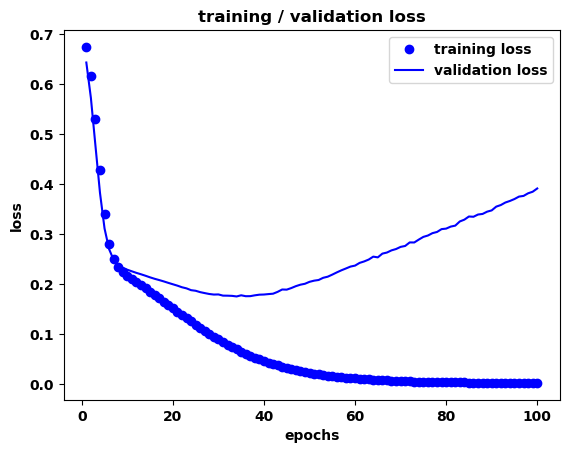

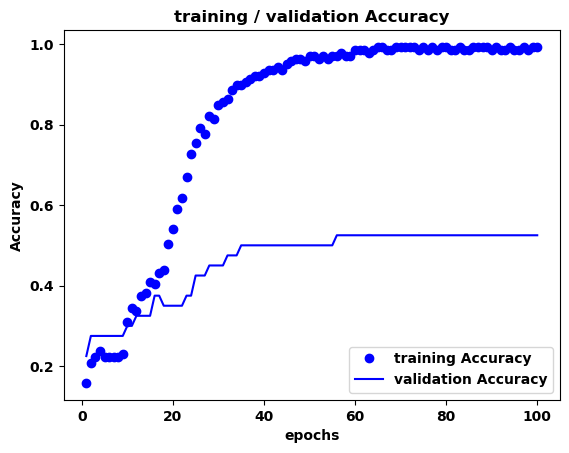

In [41]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training / validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='training Accuracy')
plt.plot(epochs, val_acc, 'b', label='validation Accuracy')
plt.title('training / validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [36]:
results = model.evaluate(test_data_new, test_labels_new)

2/2 [==============================] - 0s 5ms/step - loss: 0.3460 - accuracy: 0.6444


## GloVE Approach

Processing Embeddings

In [42]:
import os
glove_dir = './GitHub/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors' % len(embeddings_index))

Found 400000 word vectors


Now, build an embedding matrix that can be loaded into an `Embedding` layer. It must be a matrix of shape `(max_words,embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index (built during tokenization). Note that the index `0` is not supposed to stand for any word or token. It is simply a placeholder.

In [43]:
max_words = len(word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in the embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector

Building a model

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

maxlen = 1000

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(15, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_data, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_data, val_labels))

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         22400     
                                                                 
 flatten_1 (Flatten)         (None, 100000)            0         
                                                                 
 dense_74 (Dense)            (None, 64)                6400064   
                                                                 
 dense_75 (Dense)            (None, 15)                975       
                                                                 
Total params: 6,423,439
Trainable params: 6,423,439
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5/5 [==============================] - 1s 129ms/step - loss: 0.5743 - acc: 0.2806 - val_loss: 0.4148 - val_acc: 0.3250
Epoch 2/10
5/5 [=============================

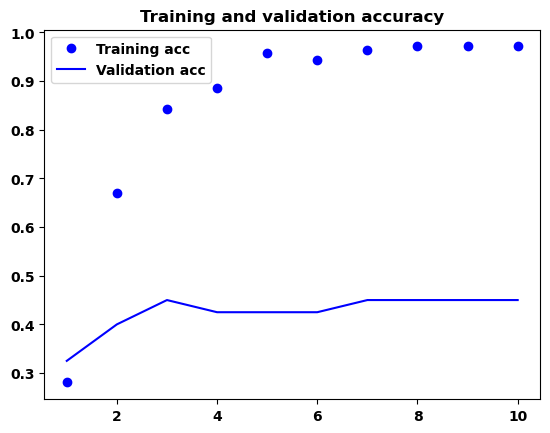

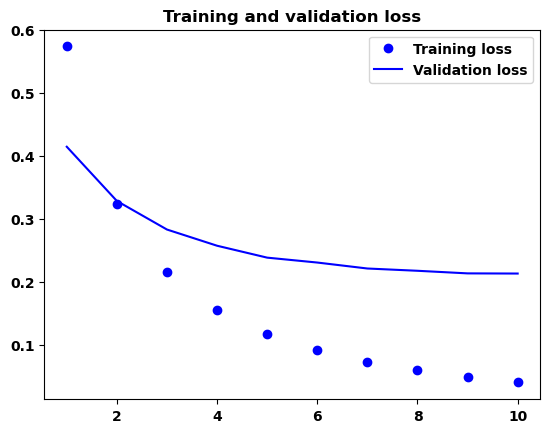

In [48]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [49]:
model.evaluate(test_data, test_labels)

1/1 [==============================] - 0s 27ms/step - loss: 0.1276 - acc: 0.7000


[0.1275945007801056, 0.699999988079071]

The Glove Approach is performing a lot better than the previous approach, reaching an accuracy of 60 % for the test data.

Next steps in continuing with classyfing the contributions could be:

- Clustering via Embeddings (nearest neighbour)
- Add wrong contributions and additional "non-sense" classes for a more diverse dataset.

### Neuer Datensatz

In [50]:
max_words = len(word_index) + 1
embedding_dim = 100
embedding_matrix_new = np.zeros((max_words, embedding_dim))

for word, i in word_index_new.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in the embedding index will be all-zeros
            embedding_matrix_new[i] = embedding_vector

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

maxlen = 1000

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(17, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix_new])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history_new = model.fit(train_data_new, train_labels_new,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_data_new, val_labels_new))

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 100)         22400     
                                                                 
 flatten_3 (Flatten)         (None, 100000)            0         
                                                                 
 dense_78 (Dense)            (None, 64)                6400064   
                                                                 
 dense_79 (Dense)            (None, 17)                1105      
                                                                 
Total params: 6,423,569
Trainable params: 6,423,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
10/10 [==============================] - 1s 93ms/step - loss: 0.4554 - acc: 0.2898 - val_loss: 0.2834 - val_acc: 0.5556
Epoch 2/10
10/10 [==========================

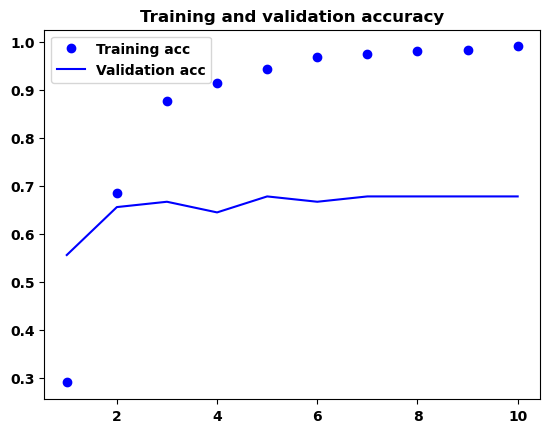

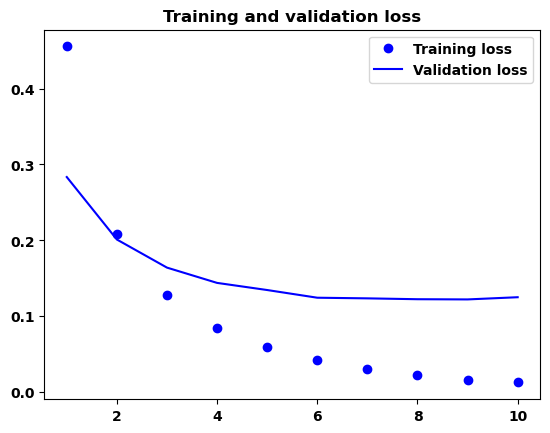

In [53]:
import matplotlib.pyplot as plt

acc = history_new.history['acc']
val_acc = history_new.history['val_acc']
loss = history_new.history['loss']
val_loss = history_new.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [54]:
model.evaluate(test_data_new, test_labels_new)

2/2 [==============================] - 0s 37ms/step - loss: 0.1400 - acc: 0.6667


[0.14004570245742798, 0.6666666865348816]